In [81]:
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import ADASYN
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.metrics import recall_score

In [83]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
glioma_grading_clinical_and_mutation_features = fetch_ucirepo(id=759) 
  
# data (as pandas dataframes) 
X = glioma_grading_clinical_and_mutation_features.data.features 
y = glioma_grading_clinical_and_mutation_features.data.targets 

## Data pre processing

In [85]:
def categorise_age(age):
    if age <= 19:
        return "Paediatric"
    elif 20 <= age <= 39:
        return "Young Adult"
    elif 40 <= age <= 64:
        return "Adult"
    else:
        return "Elderly"

X['Age_class_at_diagnosis'] = X['Age_at_diagnosis'].apply(categorise_age)

/var/folders/hf/3rv_98fd6y5b8tx745n5n1s00000gn/T/ipykernel_90397/2568762353.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Age_class_at_diagnosis'] = X['Age_at_diagnosis'].apply(categorise_age)


In [86]:
gender_mapping = {0 : 'Male', 1 : 'Female'}

X['Gender'] = X['Gender'].map(gender_mapping)

/var/folders/hf/3rv_98fd6y5b8tx745n5n1s00000gn/T/ipykernel_90397/1515168427.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Gender'] = X['Gender'].map(gender_mapping)


In [87]:
X['demographic'] = X['Gender'] + ', ' + X['Race'] + ', ' + X['Age_class_at_diagnosis']
X.drop(columns = ["Age_class_at_diagnosis", "Gender", "Race", "Age_at_diagnosis"], inplace = True)

In [88]:
demo_mapping = {
 'male, white, paediatric': 1,
 'male, black or african american, paediatric': 2,
 'male, asian, paediatric': 3,
 'male, american indian or alaska native, paediatric': 4,
 'male, white, young adult': 5,
 'male, black or african american, young adult': 6,
 'male, asian, young adult': 7,
 'male, american indian or alaska native, young adult': 8,
 'male, white, adult': 9,
 'male, black or african american, adult': 10,
 'male, asian, adult': 11,
 'male, american indian or alaska native, adult': 12,
 'male, white, elderly': 13,
 'male, black or african american, elderly': 14,
 'male, asian, elderly': 15,
 'male, american indian or alaska native, elderly': 16,
 'female, white, paediatric': 17,
 'female, black or african american, paediatric': 18,
 'female, asian, paediatric': 19,
 'female, american indian or alaska native, paediatric': 20,
 'female, white, young adult': 21,
 'female, black or african american, young adult': 22,
 'female, asian, young adult': 23,
 'female, american indian or alaska native, young adult': 24,
 'female, white, adult': 25,
 'female, black or african american, adult': 26,
 'female, asian, adult': 27,
 'female, american indian or alaska native, adult': 28,
 'female, white, elderly': 29,
 'female, black or african american, elderly': 30,
 'female, asian, elderly': 31,
 'female, american indian or alaska native, elderly': 32
}



X['demographic'] = X['demographic'].str.lower().map(demo_mapping)

## Inverse weighting

In [95]:
# Assign y to X before balancing
X['Grading'] = y

## Extract demographic column
demographic = X['demographic']

# Extract features (excluding demographic and Grading)
mutations_grading = X.drop(columns=['demographic'])

In [97]:
def assign_inverse_frequency_weights(df, group_col):
    """
    Assigns weights to each row in the dataframe inversely proportional
    to the frequency of its group in `group_col`.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        group_col (str): Column name representing demographic groups.

    Returns:
        pd.DataFrame: Original DataFrame with new 'weight' column added.
    """
    group_counts = df[group_col].value_counts()
    weights = df[group_col].map(lambda x: 1 / group_counts[x])
    weights = weights / weights.sum()  # Normalize weights to sum to 1 (optional)
    df = df.copy()
    df['weight'] = weights
    return df

In [99]:
# Apply weighting
df_weighted = assign_inverse_frequency_weights(X, 'demographic')

# Inspect weights
print(df_weighted.groupby('demographic')['weight'].mean())

demographic
1     0.025000
5     0.000403
6     0.025000
7     0.025000
9     0.000242
10    0.002941
11    0.008333
12    0.050000
13    0.000442
14    0.003846
15    0.050000
21    0.000556
22    0.006250
23    0.025000
25    0.000318
26    0.003846
27    0.025000
29    0.000694
30    0.008333
31    0.050000
Name: weight, dtype: float64


### Training and testing split

In [102]:
# Replace with your actual feature columns
X = df_weighted.drop(columns = ['Grading', 'weight'])
y = df_weighted['Grading']
weights = df_weighted['weight']

# Train/test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.1, random_state=1, stratify=y
)

X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(
    X_train, y_train, w_train, test_size=0.25, random_state=1, stratify=y_train
)

### Feature selection

In [105]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

def mrmr_feature_selection(X, y, n_features, random_state=1):
    """Performs mRMR feature selection (unweighted MI)."""
    np.random.seed(random_state)
    y = y.ravel()

    # Note: mutual_info_classif does not support sample weights directly
    mi = mutual_info_classif(X, y, random_state=random_state)
    selected = []
    remaining = list(range(X.shape[1]))

    # first pick
    first = np.argmax(mi)
    selected.append(first)
    remaining.remove(first)

    # iterative pick
    for _ in range(min(n_features - 1, len(remaining))):
        relevance = mi[remaining]
        # compute average redundancy
        red_vals = []
        for s in selected:
            for f in remaining:
                xf = X.iloc[:, f] if isinstance(X, pd.DataFrame) else X[:, f]
                xs = X.iloc[:, s] if isinstance(X, pd.DataFrame) else X[:, s]
                corr = np.corrcoef(xf, xs)[0,1]
                red_vals.append(corr)
        redundancy = np.nanmean(red_vals) if red_vals else 0
        scores = relevance - redundancy
        if len(scores) == 0:
            break
        nxt = remaining[np.argmax(scores)]
        selected.append(nxt)
        remaining.remove(nxt)

    return selected


def embedded_lasso_selection(X, y, sample_weight=None, random_state=1):
    """Performs feature selection using weighted LASSO regression."""
    np.random.seed(random_state)
    y = y.ravel()

    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    lasso = LassoCV(cv=5, max_iter=10000, random_state=random_state)
    # Pass sample_weight to respect IPW in both CV and penalty
    lasso.fit(Xs, y, sample_weight=sample_weight)

    return np.where(lasso.coef_ != 0)[0]


def mrmr_lasso_pipeline(X, y, ipw_weights=None, desired_n_features=13, buffer_mrmr=30, random_state=1):
    """
    Combines unweighted mRMR MI and weighted LASSO to select features.
    - ipw_weights: array-like of sample weights (inverse-probabilities)
    - desired_n_features: final number of features
    - buffer_mrmr: number of top mRMR features to feed into LASSO
    """
    np.random.seed(random_state)
    # flatten y
    y_arr = y.values.ravel() if hasattr(y, 'values') else y.ravel()

    # Step 1: mRMR (unweighted)
    top_mrmr = mrmr_feature_selection(X, y_arr, buffer_mrmr, random_state=random_state)
    X_mrmr = X.iloc[:, top_mrmr] if hasattr(X, 'iloc') else X[:, top_mrmr]

    # Step 2: weighted LASSO
    lasso_idx = embedded_lasso_selection(X_mrmr, y_arr, sample_weight=ipw_weights, random_state=random_state)
    final = [top_mrmr[i] for i in lasso_idx]

    # Step 3: ensure exact number of features
    if len(final) < desired_n_features:
        for feat in top_mrmr:
            if feat not in final:
                final.append(feat)
            if len(final) == desired_n_features:
                break
    else:
        final = final[:desired_n_features]

    return final


In [109]:
final_selected_features = mrmr_lasso_pipeline(X_train, y_train, ipw_weights = w_train, random_state = 1)

print("Selected Feature Indices:", final_selected_features)

Selected Feature Indices: [0, 20, 3, 4, 2, 12, 13, 19, 1, 17, 6, 9, 5]


In [111]:
X_train = X_train.iloc[:, [0, 20, 3, 4, 2, 12, 13, 19, 1, 17, 6, 9, 5]]

## GridSearchCV

In [114]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Different kernel types
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Kernel coefficient
}

# Define the model
svc = SVC()

# Perform GridSearchCV
grid_search = GridSearchCV(svc, param_grid, cv=3, scoring='f1', verbose=1, n_jobs=-1)
grid_search.fit(X_val, y_val)


# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best recall:", grid_search.best_score_)

Fitting 3 folds for each of 80 candidates, totalling 240 fits
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best recall: 0.8361581920903954


In [116]:
svc_norm = SVC(C = 10, gamma = 'scale', kernel = 'rbf', random_state = 1, probability = True)

svc_norm.fit(X_train, y_train, sample_weight = w_train)

X_test = X_test.iloc[:, [0, 20, 3, 4, 2, 12, 13, 19, 1, 17, 6, 9, 5]]

In [118]:
prediction = svc_norm.predict(X_test)
print(f'Confusion Matrix: {confusion_matrix(y_test, prediction)}')
print(f'Accuracy: {accuracy_score(y_test, prediction)}')
print(f'Sensitivity: {recall_score(y_test, prediction)}')

Confusion Matrix: [[49  0]
 [35  0]]
Accuracy: 0.5833333333333334
Sensitivity: 0.0


In [120]:
results_df = pd.DataFrame({
    'demographic': X_test['demographic'],
    'actual': y_test,
    'predicted': prediction
})

# Compute accuracy per demographic
accuracy_per_demo_IW = results_df.groupby('demographic').apply(
    lambda x: accuracy_score(x['actual'], x['predicted'])
)

# Compute sensitivity per demographic
sensitivity_per_demo_IW = results_df.groupby('demographic').apply(
    lambda x: recall_score(x['actual'], x['predicted'])
)

/Users/mollydonaghey/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [122]:
accuracy_per_demo_IW = pd.DataFrame(accuracy_per_demo_IW)
accuracy_per_demo_IW.reset_index(inplace = True)
accuracy_per_demo_IW.columns  = ['Demographic', 'Accuracy']
accuracy_per_demo_IW

,Demographic,Accuracy
0,1,1.000000
1,5,0.937500
2,9,0.375000
3,10,0.333333
4,13,0.300000
5,14,0.000000
6,21,0.909091
7,25,0.846154
8,29,0.200000
9,30,0.000000


In [124]:
sensitivity_per_demo_IW = pd.DataFrame(sensitivity_per_demo_IW)
sensitivity_per_demo_IW.reset_index(inplace = True)
sensitivity_per_demo_IW.columns  = ['Demographic', 'Sensitivity']
sensitivity_per_demo_IW

,Demographic,Sensitivity
0,1,0.0
1,5,0.0
2,9,0.0
3,10,0.0
4,13,0.0
5,14,0.0
6,21,0.0
7,25,0.0
8,29,0.0
9,30,0.0


## ROC curve

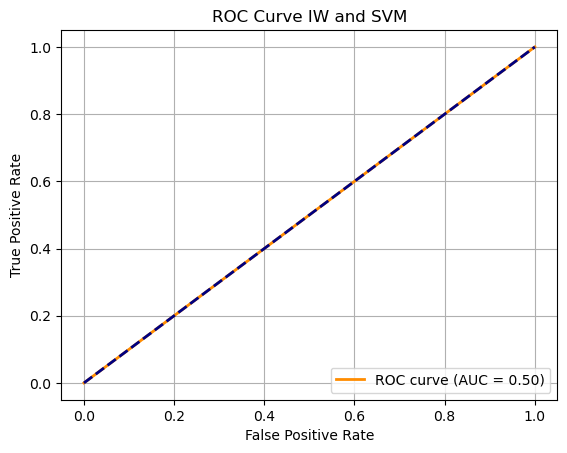

In [127]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(results_df['actual'], results_df['predicted'])

# Compute AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve IW and SVM')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [129]:
from sklearn.metrics import roc_curve, auc

# Create an empty dictionary to hold the AUC for each demographic
auc_per_demo = {}

# Group by demographic and compute AUC for each group
for demo, group in results_df.groupby('demographic'):
    fpr, tpr, _ = roc_curve(group['actual'], group['predicted'])
    auc_score = auc(fpr, tpr)
    auc_per_demo[demo] = auc_score

auc_per_demo_df = pd.DataFrame.from_dict(auc_per_demo, orient='index', columns=['AUC'])
auc_per_demo_df

### All due to chance ###

/Users/mollydonaghey/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/mollydonaghey/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/Users/mollydonaghey/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


,AUC
1,NaN
5,0.5
9,0.5
10,0.5
13,0.5
14,NaN
21,0.5
25,0.5
29,0.5
30,NaN
